In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from RegscorePy import *
from scalingAnalysis import *
from IPython.core.debugger import set_trace
import lmfit
##### This script is to run basic scaling law analyses

# User Configs


In [2]:
years = "2013-2016"
#years = "2000-2005"

# input data file
fIn = "Features"+years.replace("-","_")+".xls"

#what features to analyze
#feats = ["GDP","Violent Crime","Total Robberies","Number of Visitors (Estimate by Accommodation GDP)"]
#feats = ["GDP","Disposable Income per Household","Unemployment","Air Traffic","Connectivity (asymmetric)"]
feats = ['Ratio of Global Econ']


# feats to be plotted on a linear regression rather than log-log
linearFeats = ["Ratio of Global Econ"]

# what countries to analyze. 
countries = [[#'Australia',
#'Canada',
#'Germany',
#'Spain',
#'France',
#'United Kingdom',
#'Italy',
#'United States (Census)'
]]

# set true if running on US census data
USData = False

# minimum number of datapoints to plot
dataPlotMin = 7

includeTag = 'ALL/SEPARATE' # this plots all countries on individual country plots
#includeTag = 'ALL/COMBINED' # this plots all countries together
#includeTag = 'ALL/COMBINED+SEPARATE' # this plots each country individually plus all of EU as one (TODO: Not yet implemented)
#includeTag = 'LIST' # this allows manual lists of countries in "countries" above

# process run parameters and read in Data

In [3]:
if includeTag == 'ALL/SEPARATE':
    countries = []
    #for country in allCountries:
    countries = list(map(lambda x: [x], allCountries))
elif includeTag == 'ALL/COMBINED':
    countries = [allCountries]
elif includeTag == 'LIST':
    countries = countries
else:
    print("WHAT COUNTRIES DO YOU WANT?")

# map, mapping countryname to dataframe
data = {}

# TODO: Include error bars


if USData:
    allCountries = ['United States (Census)']
    countries = [['United States (Census)']]

for country in allCountries:
    data[country] = pd.read_excel(fIn,sheet_name=country)

In [7]:
y0 = 0.0074266411


def connFunc(pop, y1,n,Beta_net,Beta_int):
#def connFunc(pop, y1,n):
    prediction = n*(y0*pop**(Beta_net) - y1*pop**(Beta_int))
    #prediction = n*(y0*pop**(1.12) - y1*pop**(1.08))
    with np.nditer(prediction, op_flags=['readwrite']) as it:
        for x in it:
            if x < 0:
                x[...] = 1
    return prediction

def logResidual(params, x, data):
    #model = connFunc(x,params['y1'],params['n'])
    model = connFunc(x,params['y1'],params['n'],params['Beta_net'],params['Beta_int'])
    return np.log(data)-np.log(model)

#connTag = "Global Firm Presence (without Connectivity)"
connTag = "Air Traffic"

UKData = data["United Kingdom"][["Population",connTag]].dropna()
#y0 = 5080677.3/10287135.8


externalities = UKData[connTag]*100000

params = lmfit.Parameters()
#params.add_many(('n',790,True),('y1',y0,True,0))
params.add_many(('n',790,True),('y1',y0,True,0),('Beta_net',1.12,False,1,1.3),('Beta_int',1.08,False,0.8,1.3))

fit = lmfit.minimize(logResidual, params, args=(UKData["Population"], externalities))
fitParams = fit.params
fitParams.pretty_print()


#print(connFunc(1000))

plt.figure("test connections")

plt.loglog(UKData["Population"],externalities,'bo',label="Air Traffic")
x_space = np.linspace(np.min(UKData["Population"]),np.max(UKData["Population"]),1001)
#plt.loglog(1,1)
plt.loglog(x_space,connFunc(x_space,fitParams['y1'],fitParams['n'],fitParams['Beta_net'],fitParams['Beta_int']),':r',label="Prediction")
#plt.loglog(x_space,connFunc(x_space,fitParams['y1'],fitParams['n']),':r')

plotName = "Externalities Prediction (UK "+years+")"

plt.title(plotName)
plt.legend()
plt.xlabel('Population')
plt.ylabel(connTag)
#save to file

outDir = "Figures/InclusiveExclusive/"
outName = outDir + "UK_"+years+".png"

plt.savefig(outName)
#plt.show()
plt.close()


Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
Beta_int      1.08      0.8      1.3     None    False     None     None
Beta_net      1.12        1      1.3     None    False     None     None
n         3.13e+06     -inf      inf     None     True     None     None
y1        2.133e-10        0      inf     None     True     None     None


Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
Beta_int      1.09        1      1.3        0    False     None     None
Beta_net      1.11        1      1.3        0    False     None     None
n            78.33     -inf      inf    58.03     True     None     None
y1         0.01051        0      inf 0.004046     True     None     None


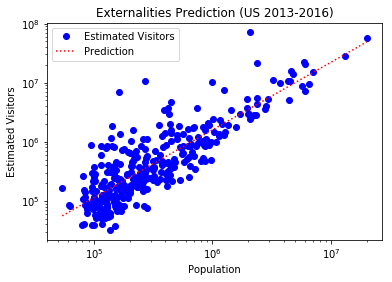

In [6]:
USData = pd.read_excel("FeaturesUS2013_2016.xls")
USData = USData[["Population","Number of Visitors (Estimate by Accommodation GDP)"]].dropna()
pop = USData["Population"]
visitors = USData["Number of Visitors (Estimate by Accommodation GDP)"]
#y0 = 15080677.3/10287135.8
y0 = 0.012414861898723

def connFunc(pop, y1,n,Beta_net,Beta_int):
    #prediction = n*(y0*pop**(1.11) - y1*pop**(1.09))
    prediction = n*(y0*pop**(Beta_net) - y1*pop**(Beta_int))
    with np.nditer(prediction, op_flags=['readwrite']) as it:
        for x in it:
            if x < 0:
                x[...] = 1
    return prediction

def logResidual(params, x, data):
    #model = connFunc(x,params['y1'],params['n'])
    model = connFunc(x,params['y1'],params['n'],params['Beta_net'],params["Beta_int"])
    return np.log(data)-np.log(model)


#y0 = 5080677.3/10287135.8
#TODO: Get actual y0 values. These are estimates

params = lmfit.Parameters()
params.add_many(('n',66,True),('y1',y0,True,0),('Beta_net',1.11,False,1,1.3),('Beta_int',1.09,False,1,1.3))

fit = lmfit.minimize(logResidual, params, args=(pop,visitors))
fitParams = fit.params
fitParams.pretty_print()

plt.figure("test connections")
plotName = "Externalities Prediction (US "+years+")"

plt.loglog(pop,visitors,'bo',label='Estimated Visitors')
x_space = np.linspace(np.min(pop),np.max(pop),1001)
#plt.loglog(x_space,connFunc(x_space, fitParams['y1'],fitParams['n']),':r')
plt.loglog(x_space,connFunc(x_space, fitParams['y1'],fitParams['n'],fitParams['Beta_net'],fitParams['Beta_int']),':r',label="Prediction")
plt.title(plotName)
plt.legend()
plt.xlabel('Population')
plt.ylabel("Estimated Visitors")
#save to file

outDir = "Figures/InclusiveExclusive/"
outName = outDir + "US_"+years+".png"

plt.savefig(outName)

plt.show()
plt.close()

# Run Analysis

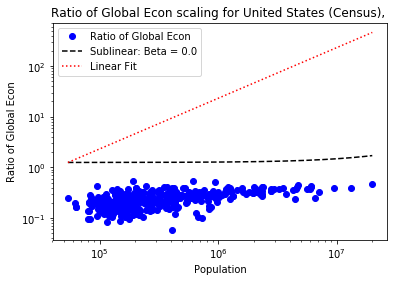

In [12]:
for feat in feats:
    for countryList in countries:
        plotData = getDataFromList(data,countryList,["Population",feat])

        # skip over countryLists without data
        if plotData.empty:
            msg = 'No Data for country {} and feature {}'.format(country,feat)
            print(msg)
            continue

        # skip over countryLists with less than a set number of datapoints
        if len(list(plotData.index)) < dataPlotMin:
            msg = 'Not Enough Data for country {} and feature {}'.format(country,feat)
            print(msg)
            continue

        #extract Population as x-axis and the feature you're analyzing as the y-axes, such as GDP
        x_pop = plotData["Population"]
        y_feat = plotData[feat]

        # get scaling parameters
        Beta,y0 = getScaleParams(plotData,feat,linearFeats) 


        # plot standard scaling distributions

        countryListName = ""
        if includeTag == 'ALL/COMBINED':
            countryListName = "AllCountries"
        else:
            for country in countryList:
                app = country + "-"
                countryListName = countryListName + (app)
        outDir = "Figures/ScalingFeatures/"+years
        outName = outDir + "/" +countryListName[:-1]+"_"+feat+".png"

        plt.figure(outName)

        if Beta>1:
            lbl = "Superlinear: Beta = "+str(round(Beta,3))
        elif Beta<1:
            lbl = "Sublinear: Beta = "+str(round(Beta,3))
        else:
            lbl = "Linear, Beta = 1"

        #linFit = np.polyfit(plotData["Population"],plotData[feat],1)

        # plot scaling fitting FIXME 
        if feat in linearFeats:
            plt.loglog(x_pop, y_feat, 'bo')
            x_space = np.linspace(np.min(x_pop),np.max(x_pop),len(x_pop))
            plt.loglog(x_space, Beta*x_space+y0, '--k',label=lbl)

        else:
            plt.loglog(x_pop, y_feat, 'bo')
            x_space = np.linspace(np.min(x_pop),np.max(x_pop),len(x_pop))
            plt.loglog(x_space, y0*x_space**Beta, '--k',label=lbl)

            # plot null hypothesis linear fit  FIXME
        plt.loglog(x_space, y0*np.min(x_pop)**Beta/np.min(x_pop)*x_space, ':r',label="Linear Fit") 




        # create name for plot
        countryListName = ""
        for country in countryList:
            app = country + ", "
            countryListName = countryListName + (app)
        plotName = feat + " scaling for " + countryListName

        # create labels, legends, etc
        plt.title(plotName)
        plt.legend()
        plt.xlabel('Population')
        yLab = feat
        plt.ylabel(yLab)
        plt.show()
        #save to file

        plt.savefig(outName)
        plt.close()

In [13]:
data

{'United States (Census)':                                                   City        State  \
 0    Las Vegas-Henderson-Paradise (NV) / Las Vegas-...           NV   
 1    New York-Newark-Jersey City (NY-NJ-PA) / New Y...     NY-NJ-PA   
 2    Los Angeles-Long Beach-Anaheim (CA) / Los Ange...           CA   
 3    Miami-Fort Lauderdale-West Palm Beach (FL) / M...           FL   
 4    Orlando-Kissimmee-Sanford (FL) / Orlando-Kissi...           FL   
 5    Washington-Arlington-Alexandria (DC-VA-MD-WV) ...  DC-VA-MD-WV   
 6    San Francisco-Oakland-Hayward (CA) / San Franc...           CA   
 7    Dallas-Fort Worth-Arlington (TX) / Dallas-Fort...           TX   
 8    Boston-Cambridge-Newton (MA-NH) / Boston-Cambr...        MA-NH   
 9         San Diego-Carlsbad (CA) / San Diego-Carlsbad           CA   
 10   Phoenix-Mesa-Scottsdale (AZ) / Phoenix-Mesa-Sc...           AZ   
 11   Detroit-Warren-Dearborn (MI) / Detroit-Warren-...           MI   
 12   Atlantic City-Hammonton (NJ) / A

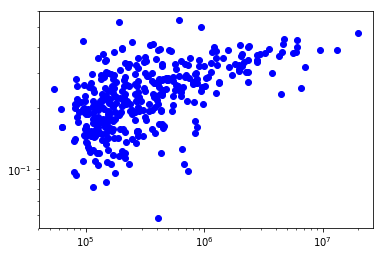

In [17]:
#data = data['United States (Census)']

GDPRatio = data['Ratio of Global Econ']
pop = data['Population']


plt.figure()
plt.loglog(pop,GDPRatio,'bo')
plt.show()

